In [1]:
import numpy as np
import pandas as pd
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab.envs.time_series import timeSeriesEnv
from rl4greencrab import evaluate_agent, multiConstAction, simulator
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from stable_baselines3 import PPO, TD3
from stable_baselines3.common.env_util import make_vec_env
from sb3_contrib import TQC, RecurrentPPO

In [2]:
from rl4greencrab.envs.time_series import timeSeriesEnv

In [3]:
config = {
    'base_env' : greenCrabMonthEnvNormalized(config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
}),
    'N_mem':9
}

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [4]:
env = timeSeriesEnv(config)

In [40]:
env.step(np.array([0.1, 0.1 , 0]))

({'crabs': array([[-0.9984417 , -0.82022988],
         [-0.99948752, -0.77656255],
         [-0.9994958 , -0.50499247],
         [-0.99827915, -0.57022174],
         [-0.99489164, -0.72990764],
         [-0.99238747, -0.78285327],
         [-0.99324167, -0.79501826],
         [-0.99532086, -0.81089233],
         [-0.99775833, -0.81077945]]),
  'months': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11])},
 -0.2880676994840367,
 False,
 False,
 {})

In [41]:
env = timeSeriesEnv(config)
vec_env = make_vec_env(timeSeriesEnv, n_envs=12, env_kwargs={'config':config})

In [42]:
model = PPO('MultiInputPolicy', vec_env, verbose=0, tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=10_000, 
	progress_bar=True,
)
model.save("ppo_month_memory")

Output()

In [14]:
ppoAgent = PPO.load("ppo_month_memory", device="cpu")

In [22]:
evalEnv = timeSeriesEnv(config)

In [23]:
N_EPS = 30

ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)

import ray
ray.shutdown()

In [24]:
ppo_rew

-18.516685930693782

observation name is ['obs0', 'obs1']


,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.000000,-1.0,-0.146087,-0.162855,-0.584623,0.000000,0
1,1,-0.998196,7.0,-0.168052,-0.175257,-0.644195,-0.150796,0
2,2,-0.998002,8.0,-0.183600,-0.167124,-0.626690,-0.288306,0
3,3,-0.997469,9.0,-0.194486,-0.179354,-0.644935,-0.429022,0
4,4,-0.996891,10.0,-0.193014,-0.166508,-0.624973,-0.565165,0


<Axes: xlabel='t'>

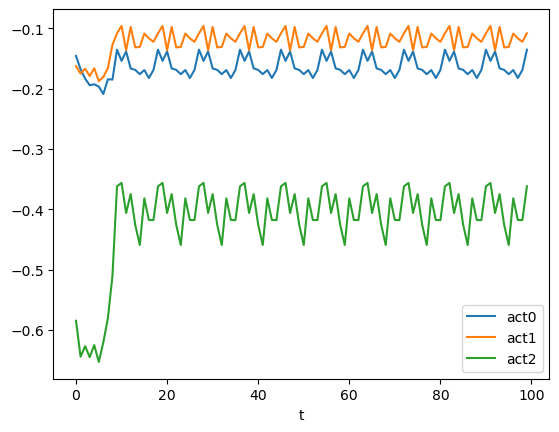

In [18]:
ppoData = simulator(env = evalEnv, agent = ppoAgent).simulate_full_named_obs_acts_time_series()
ppoDataDF = pd.DataFrame(ppoData)
display(ppoDataDF.head())
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])

<Axes: xlabel='t'>

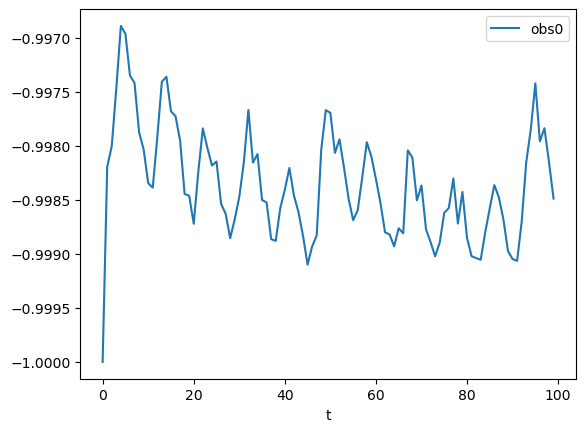

In [19]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['obs0'])